In [4]:
# import dependencies
import xarray as xr
import numpy as np
from os.path import join
import matplotlib.pyplot as plt
import hydromt
from hydromt_sfincs import SfincsModel

In [39]:
!hydromt update sfincs ./semarang_sfincs_150 -o ./semarang_sfincs_coastal_rt -i sfincs_update_coastal_semarang.ini -vv --dd

2022-07-12 16:03:30,172 - update - log - DEBUG - Appending log messages to file C:\Users\ampolini\Workingfolder\hydromt_sfincs-main\examples\semarang_sfincs_coastal_rt\hydromt.log.
2022-07-12 16:03:30,172 - update - log - INFO - HydroMT version: 0.4.5
2022-07-12 16:03:30,172 - update - main - INFO - Updating sfincs model at C:\Users\ampolini\Workingfolder\hydromt_sfincs-main\examples\semarang_sfincs_150 (r).
2022-07-12 16:03:30,173 - update - main - INFO - Output dir: C:\Users\ampolini\Workingfolder\hydromt_sfincs-main\examples\semarang_sfincs_coastal_rt
2022-07-12 16:03:30,173 - update - main - INFO - User settings:
2022-07-12 16:03:30,185 - update - model_plugins - DEBUG - Loaded model plugin 'sfincs = hydromt_sfincs.sfincs.SfincsModel' (0.2.1)
2022-07-12 16:03:30,186 - update - model_api - INFO - Initializing sfincs model from hydromt_sfincs (v0.2.1).
2022-07-12 16:03:30,186 - update - data_adapter - INFO - Adding deltares_data v0.0.6 sources from https://github.com/DirkEilander/hyd

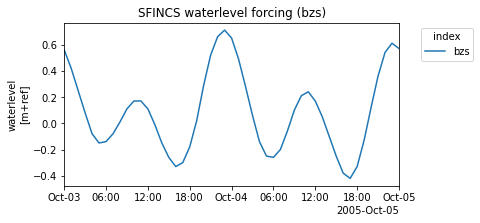

In [40]:
mod = SfincsModel(root="semarang_sfincs_coastal_rt", mode="r")
#mod.forcing.pop('bzs', None)  # let's focus on precip for now
_ = mod.plot_forcing()

In [41]:
sfincs_root = "semarang_sfincs_coastal_rt"  # (relative) path to sfincs root
mod = SfincsModel(sfincs_root, mode="r", deltares_data= True)

Overwriting data source dtu10mdt_egm96.
Overwriting data source gcn250.
Overwriting data source gebco.
Overwriting data source gtsm_codec_reanalysis_hourly_v1.
Overwriting data source merit_hydro.
Overwriting data source osm_coastlines.
Overwriting data source vito.


In [42]:
hmax = mod.results['hmax']
hmax = hmax.reindex(y=list(reversed(hmax['y'].values))) # change orientation to N -> S
hmax.raster.to_raster(join(mod.root, 'gis', 'hmax.tif'), compress='LZW')

In [43]:
print(mod.data_catalog["gswo"])
gswo = mod.data_catalog.get_rasterdataset("gswo", buffer=10)
# permanent water where water occurence > 5%
gswo_mask = gswo.raster.reproject_like(mod.staticmaps, method="max") <= 3

{'category': 'hydrography',
 'data_type': 'RasterDataset',
 'driver': 'raster',
 'paper_doi': '10.1038/nature20584',
 'paper_ref': 'Pekel et al. (2016)',
 'path': 'p:\\wflow_global\\hydromt\\hydrography\\gswo\\occur.vrt',
 'source_url': 'https://global-surface-water.appspot.com/download',
 'source_version': 'v1_1_2019'}


nodata value missing for p:\wflow_global\hydromt\hydrography\gswo\occur.vrt


In [44]:
hmin = 0.1  # minimum flood depth [m] to plot
da_hmax = mod.results["hmax"]  # hmax is computed from zsmax - zb
# get overland flood depth with GSWO and set minimum flood depth
da_hmax_fld = da_hmax.where(gswo_mask).where(da_hmax > hmin)
# update attributes for colorbar label later
da_hmax.attrs.update(long_name="flood depth", unit="m")

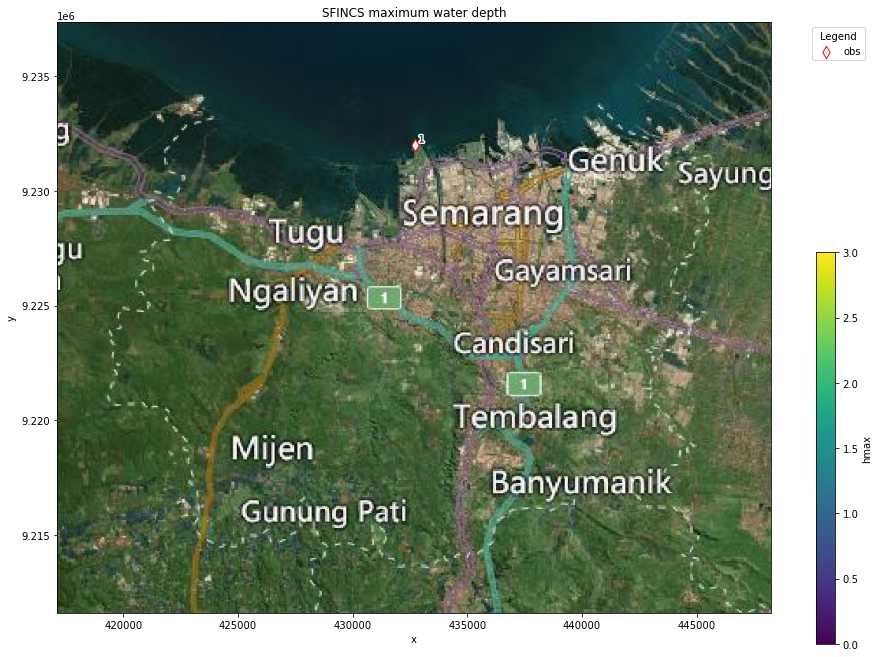

In [45]:
# create hmax plot and save to mod.root/figs/hmax.png
fig, ax = mod.plot_basemap(
    fn_out=None,
    variable=None,
    bmap="sat",
    geoms=["src", "obs"],
    plot_bounds=False,
    figsize=(16, 12),
)
# plot overland flooding based on gswo mask and mimum flood depth
cbar_kwargs = {"shrink": 0.6, "anchor": (0, 0)}
cax_fld = da_hmax_fld.plot(
    ax=ax, vmin=0, vmax=3.0, cmap=plt.cm.viridis, cbar_kwargs=cbar_kwargs
)

ax.set_title(f"SFINCS maximum water depth")
plt.savefig(join(mod.root, 'figs', 'hmax.png'), dpi=225, bbox_inches="tight")

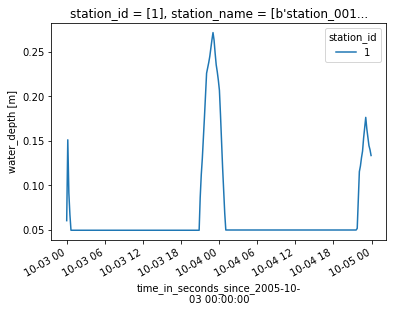

In [46]:
# point_h contains the water depths at the sfincs.obs gauge locations
# see mod.plot_basemaps (or next figure) for the location of the observation points
# make sure that the point ore not negative
h_point = mod.results["point_h"].rename({"stations": "station_id"})
h_point["station_id"] = h_point["station_id"].astype(int)
_ = h_point.plot.line(
    x="time",
)
plt.savefig(join(mod.root, 'figs', 'spatial_ref.png'), dpi=225, bbox_inches="tight")

In [47]:
import pandas as pd
h_df = h_point.reset_coords(drop=True).to_dataframe().unstack()
pd.set_option ('display.max_rows', None)
h_df.columns =  h_point['station_id'].values
h_df[1]>0.1

time
2005-10-03 00:00:00.000000000    False
2005-10-03 00:10:14.851867675     True
2005-10-03 00:20:19.168823242    False
2005-10-03 00:30:21.297485351    False
2005-10-03 00:40:29.158691406    False
2005-10-03 00:50:38.518310546    False
2005-10-03 01:00:42.900146484    False
2005-10-03 01:10:44.437988281    False
2005-10-03 01:20:47.697265625    False
2005-10-03 01:30:54.094726562    False
2005-10-03 01:41:00.934082031    False
2005-10-03 01:51:09.543945312    False
2005-10-03 02:01:16.401367187    False
2005-10-03 02:11:17.709960937    False
2005-10-03 02:21:20.794921875    False
2005-10-03 02:31:28.099609375    False
2005-10-03 02:41:34.838867187    False
2005-10-03 02:51:43.433593750    False
2005-10-03 03:01:51.135742187    False
2005-10-03 03:11:52.300781250    False
2005-10-03 03:21:55.208984375    False
2005-10-03 03:32:03.315429687    False
2005-10-03 03:42:09.767578125    False
2005-10-03 03:52:18.029296875    False
2005-10-03 04:02:27.029296875    False
2005-10-03 04:12:27.

In [49]:
sum(h_df[1])/6

3.1455647349357605